## Forecasting Using ARIMA Model

In [45]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf

from datetime import date, datetime
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


#### Load Dataset

In [60]:
df = pd.read_csv('final.csv')
df.head()

,date,BEVERAGES,BREAD/BAKERY,CLEANING,DAIRY,DELI,GROCERY I,MEATS,PERSONAL CARE,POULTRY,PRODUCE
0,2015-01-01,3528.0,676.24000,850.0,875.0,357.08200,3125.000,479.767000,203.0,279.169980,105.0
1,2015-01-02,111353.0,29702.92898,83431.0,43474.0,20804.69500,245045.337,24370.203999,23581.0,26814.086005,756.0
2,2015-01-03,110296.0,29305.08506,83648.0,45711.0,20014.19500,242694.753,21044.533846,24531.0,24995.854050,595.0
3,2015-01-04,122463.0,38390.82610,92456.0,56921.0,22452.49399,281467.988,22198.505007,27428.0,27507.856975,272.0
4,2015-01-05,88624.0,29377.54303,76070.0,43653.0,15715.71800,225516.495,16451.880920,20566.0,20565.498000,72.0


### Forecasting for feature PRODUCE

In [65]:
# Setting variables
feature = 'PRODUCE'
prediction_days = 45
forecast_start_date = datetime(2017, 7, 1)

# Preparing the data
df_produce_copy = df[['date', feature]].copy()
df_produce_copy = df_produce_copy.rename(columns={'date': 'ds', feature: 'y'})
df_produce_copy['y'] = pd.to_numeric(df_produce_copy['y'])
df_produce_copy['ds'] = pd.to_datetime(df_produce_copy['ds'])

# Splitting into train data
train_data = df_produce_copy[df_produce_copy['ds'] < forecast_start_date]

# Set the 'ds' column as the index for time series data
train_data.set_index('ds', inplace=True)

#### ARIMA Model Implementation

ARIMA Parameters:
- p: Number of autoregressive terms.
- d: Degree of differencing.
- q: Number of moving average terms.

In [66]:
# Fit an ARIMA model on the training data
# Here, I use (p, d, q) values for ARIMA. 
# For simplicity, I'll use ARIMA(1, 1, 1) here as an example.
p, d, q = 1, 1, 1
arima_model = sm.tsa.ARIMA(train_data['y'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Generate forecasts for the next 'prediction_days'
forecast_index = pd.date_range(start=forecast_start_date, periods=prediction_days, freq='D')
forecast = arima_model_fit.forecast(steps=prediction_days)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'ds': forecast_index, 'yhat': forecast})

# Prepare the true test data for evaluation (30 days of actual data after the forecast_start_date)
df_produce_copy = df_produce_copy.rename(columns={'date': 'ds', 'y': 'ytrue'})
test_data = df_produce_copy[
    (df_produce_copy['ds'] >= pd.to_datetime(forecast_start_date))]

# Merge predicted values and actual values for evaluation
df_result = pd.merge(forecast_df, test_data, on='ds')
mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
print(f"MAPE: {mape:.4f}")  # MAPE in fraction


MAPE: 0.1386


e:\Data Science Bootcamp\DS_W1\sales_data\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


#### Implementaion of ARIMA model with the best values for p, d, q

To fine-tune the ARIMA model's parameters p, d, and q, you can use a combination of manual methods (such as ACF and PACF plots) and automated methods (like grid search or cross-validation)

There are various ways to choose the values of parameters of the ARIMA model. Without being confused we can do this using the following steps:

* Test for stationarity using the augmented dickey fuller test.
* If the time series is stationary try to fit the ARMA model, and if the time series is non-stationary then seek the value of d. 
* If the data is getting stationary then draw the autocorrelation and partial autocorrelation graph of the data.
* Draw a partial autocorrelation graph(ACF) of the data. This will help us in finding the value of p because the cut-off point to the PACF is p. 
* Draw an autocorrelation graph(ACF) of the data. This will help us in finding the value of q because the cut-off point to the ACF is q.        


##### Finding the value of the d parameter

In [67]:
adf_result = adfuller(train_data['y'])
print(f'ADF Statistic:  {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic:  -2.329504924046549
p-value: 0.16262851935623407


Here we can see that the p-value is more than 0.05 this means our null hypothesis will be rejected and we will take this series as non-stationary.
Lets plot the data.

<Axes: xlabel='ds'>

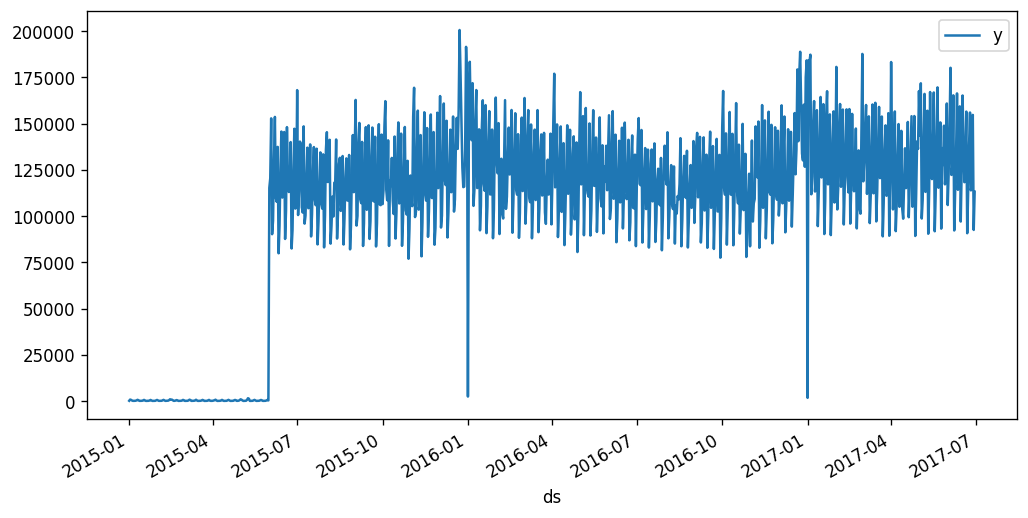

In [68]:
train_data.plot(figsize=(10, 5))

Here the plot is not staionary, we can try different values of d (1, 2, etc.) until the series is stationary.


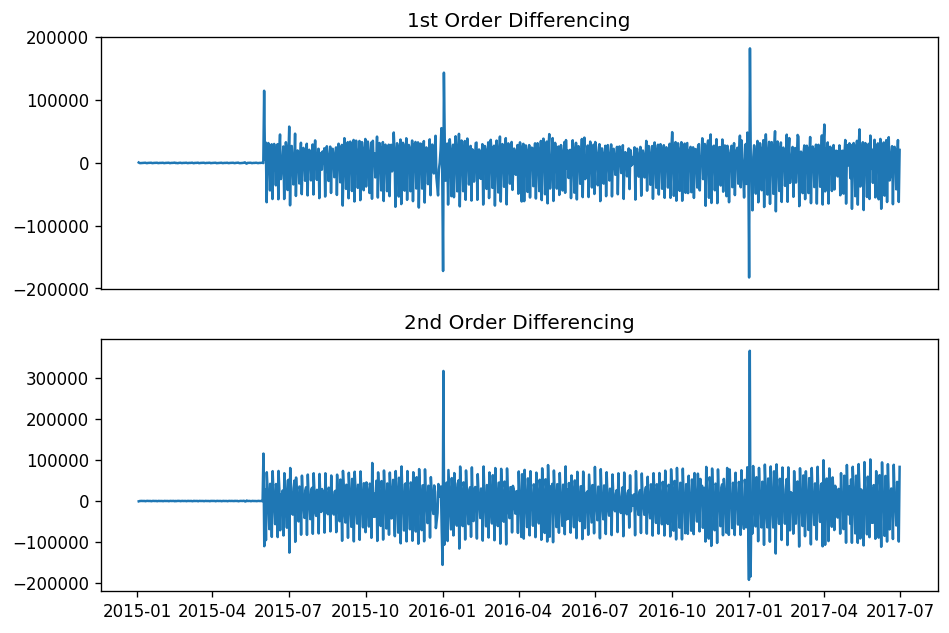

In [69]:
plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})
# 1st Differencing
fig, (ax1, ax2) = plt.subplots(2)
ax1.plot(train_data['y'].diff())
ax1.set_title('1st Order Differencing')
ax1.axes.xaxis.set_visible(False)

# 2nd Differencing
ax2.plot(train_data['y'].diff().diff()); 
ax2.set_title('2nd Order Differencing')
plt.show()

Here the time series has become stationary right after first differential, so we choose d=1

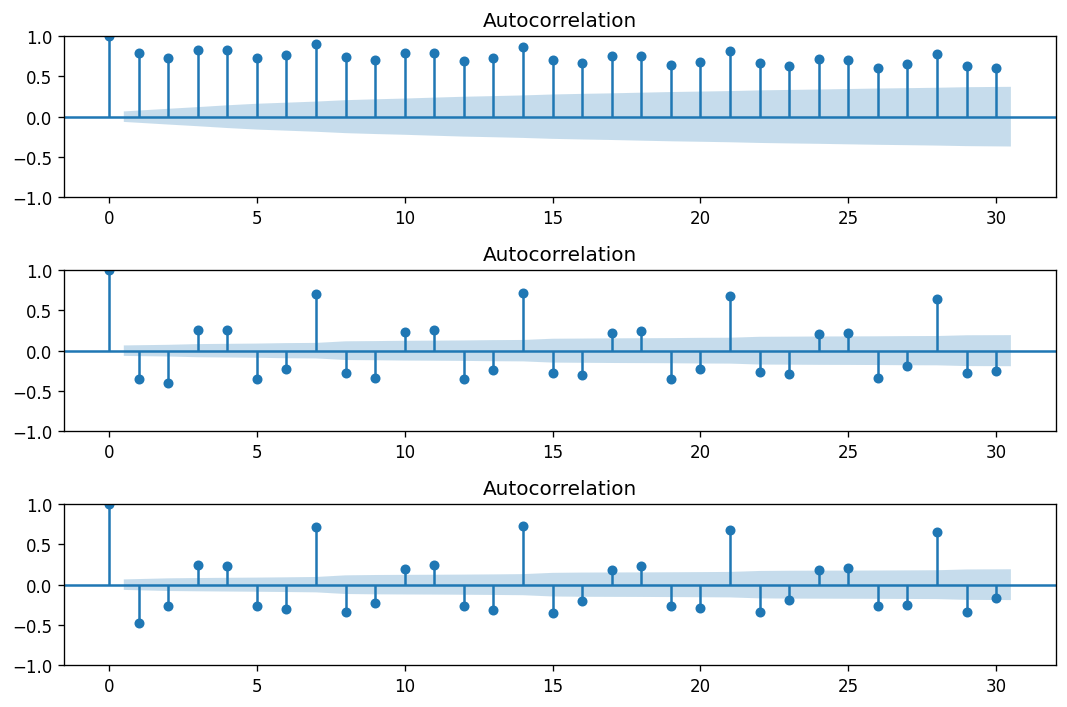

In [70]:
fig, (ax1, ax2, ax3) = plt.subplots(3)
plot_acf(train_data['y'], ax=ax1)
plot_acf(train_data['y'].diff().dropna(), ax=ax2)
plot_acf(train_data['y'].diff().diff().dropna(), ax=ax3)
# Adjust layout and display the plot
plt.tight_layout()
plt.show()

##### Finding the value of the p parameter

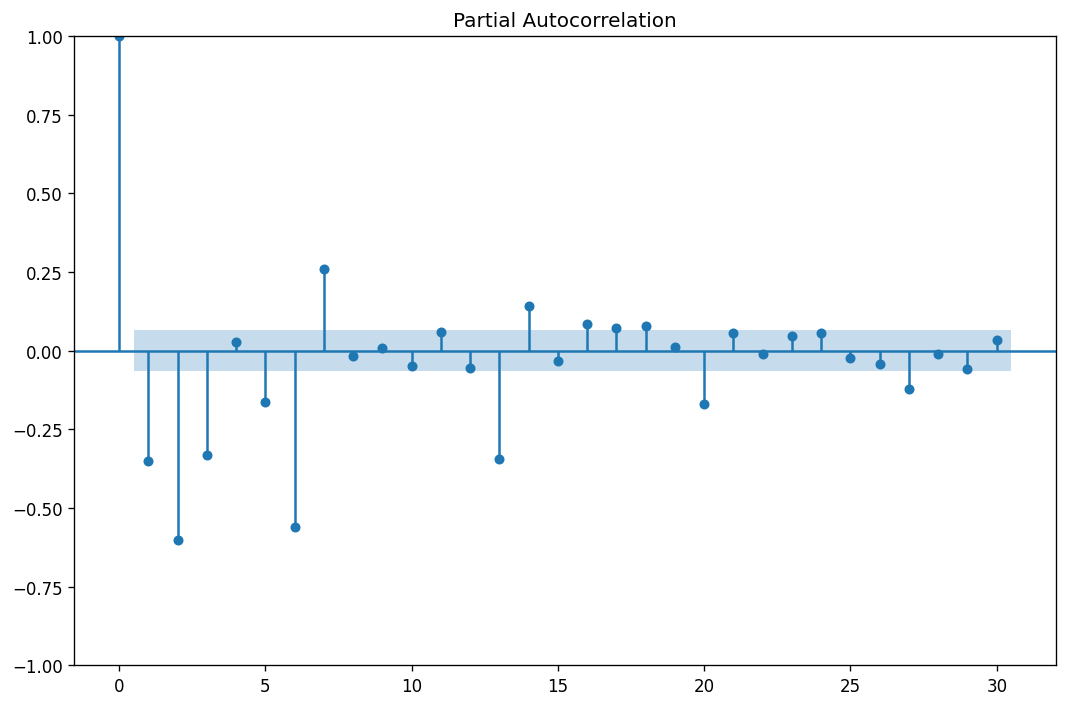

In [74]:
plot_pacf(train_data['y'].diff().dropna())
plt.tight_layout()
plt.show()

1. Ignore the 0th one as this is a spike
2. Check the lag which is very close/inside to the dense part
3. In our case the 4th one is the closest
4. P optimal value using the plot is 3

##### Finding the value of the q parameter

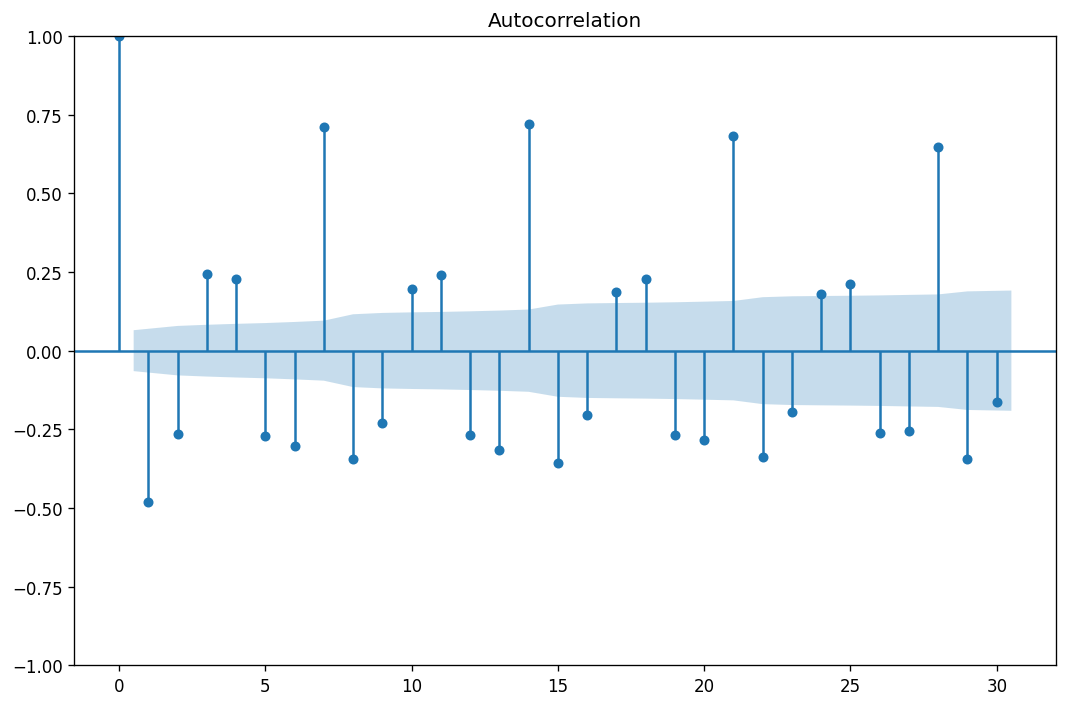

In [73]:
plot_acf(train_data['y'].diff().diff().dropna())
plt.tight_layout()
plt.show()

1. Ignore the 0th one
2. Check the antenna which is very close/inside to the dense part
3. In our case the 5th one is the closest, so use the “n-1” formula
4. Q optimal value using the plot is 4


#### Fine-tuning ARIMA with AIC/BIC using grid search method

One way to compare different ARIMA model orders is to fit each model to the same data set and calculate the AIC and BIC values for each model. Then, you can rank the models according to their AIC or BIC values and choose the model with the lowest value. Alternatively, you can use a grid search algorithm that automatically tests a range of possible model orders and selects the one that minimizes the AIC or BIC. 

In [75]:
# Try different combinations of (p, d, q) values
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

best_aic = np.inf
best_bic = np.inf
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train_data['y'], order=(p, d, q))
                model_fit = model.fit()
                
                # Get AIC and BIC
                aic = model_fit.aic
                bic = model_fit.bic
                
                # Track the best model
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                
                if bic < best_bic:
                    best_bic = bic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order based on AIC: {best_order}")
print(f"Best ARIMA order based on BIC: {best_order}")


Best ARIMA order based on AIC: (3, 1, 4)
Best ARIMA order based on BIC: (3, 1, 4)


Now, I'll choose the best value of p, q, d and train my ARIMA model

In [17]:
# Fit an ARIMA model on the training data.
p, d, q = 3, 1, 4
arima_model = sm.tsa.ARIMA(train_data['y'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Generate forecasts for the next 'prediction_days'
forecast_index = pd.date_range(start=forecast_start_date, periods=prediction_days, freq='D')
forecast = arima_model_fit.forecast(steps=prediction_days)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'ds': forecast_index, 'yhat': forecast})

# Prepare the true test data for evaluation (30 days of actual data after the forecast_start_date)
df_produce_copy = df_produce_copy.rename(columns={'date': 'ds', 'y': 'ytrue'})
test_data = df_produce_copy[
    (df_produce_copy['ds'] >= pd.to_datetime(forecast_start_date))]

# Merge predicted values and actual values for evaluation
df_result = pd.merge(forecast_df, test_data, on='ds')
mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
print(f"MAPE: {mape:.4f}")  # MAPE in fraction


MAPE: 0.1048


e:\Data Science Bootcamp\DS_W1\sales_data\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


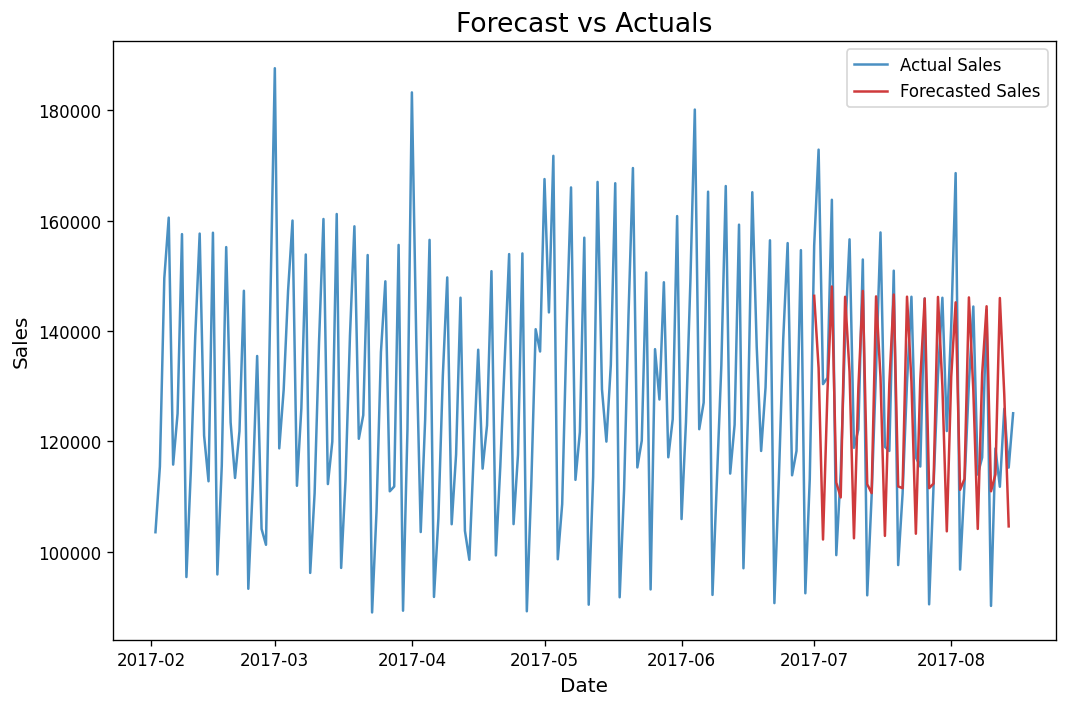

In [44]:
df_ptlot = df_produce_copy[(df_produce_copy['ds']>datetime(2017,2,1))]

# Plot historical data
plt.plot(df_ptlot.ds, df_ptlot['ytrue'], label='Actual Sales', color='#4a90c2')

# Plot forecasted values
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecasted Sales', color='#cf3a3c')

# Add titles and labels
plt.title("Forecast vs Actuals", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Lets check for some other products

### Forecasting for feature DIARY

In [76]:
# Setting variables
feature = 'DAIRY'
prediction_days = 45
forecast_start_date = datetime(2017, 7, 1)

# Preparing the data
df_produce_copy = df[['date', feature]].copy()
df_produce_copy = df_produce_copy.rename(columns={'date': 'ds', feature: 'y'})
df_produce_copy['y'] = pd.to_numeric(df_produce_copy['y'])
df_produce_copy['ds'] = pd.to_datetime(df_produce_copy['ds'])

# Splitting into train data
train_data = df_produce_copy[df_produce_copy['ds'] < forecast_start_date]

# Set the 'ds' column as the index for time series data
train_data.set_index('ds', inplace=True)

In [77]:
adf_result = adfuller(train_data['y'])
print(f'ADF Statistic:  {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic:  -2.4454261080310737
p-value: 0.12932339168579338


<Axes: xlabel='ds'>

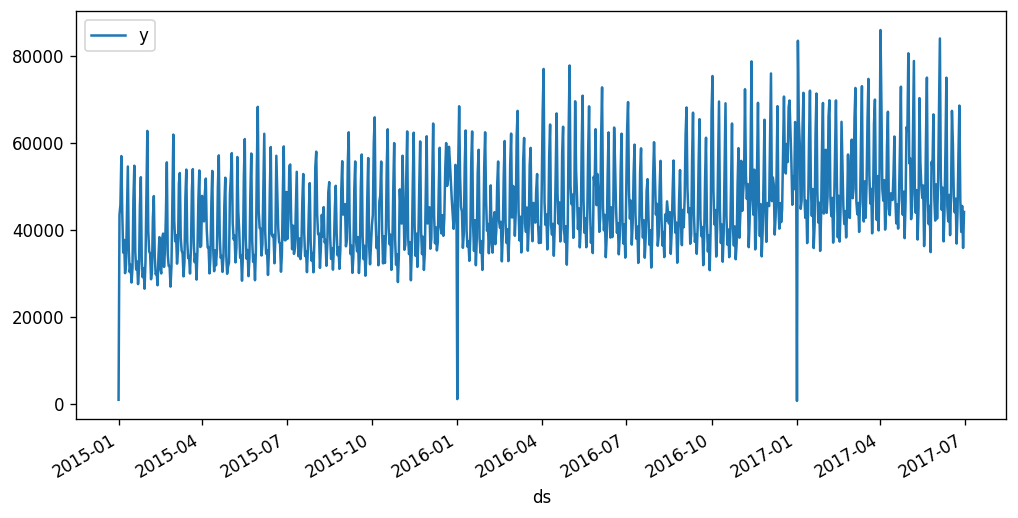

In [78]:
train_data.plot(figsize=(10, 5))

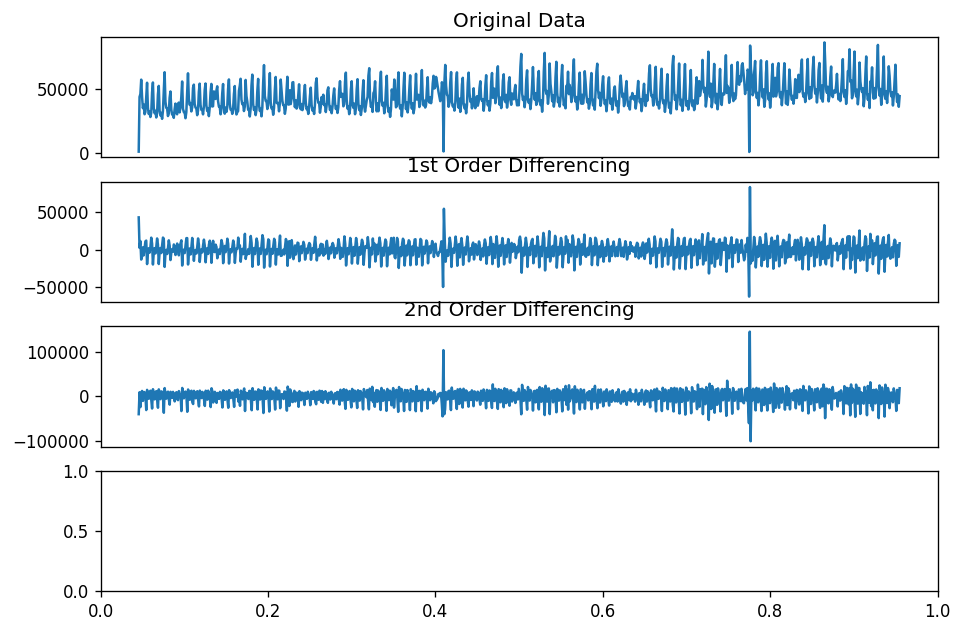

In [84]:
plt.rcParams.update({'figure.figsize':(9,6), 'figure.dpi':120})

fig, (ax, ax1, ax2, ax3) = plt.subplots(4)

ax.plot(train_data['y'])
ax.set_title('Original Data')
ax.axes.xaxis.set_visible(False)

# 1st Differencing
ax1.plot(train_data['y'].diff())
ax1.set_title('1st Order Differencing')
ax1.axes.xaxis.set_visible(False)

# 2nd Differencing
ax2.plot(train_data['y'].diff().diff()); 
ax2.set_title('2nd Order Differencing')
ax2.axes.xaxis.set_visible(False)


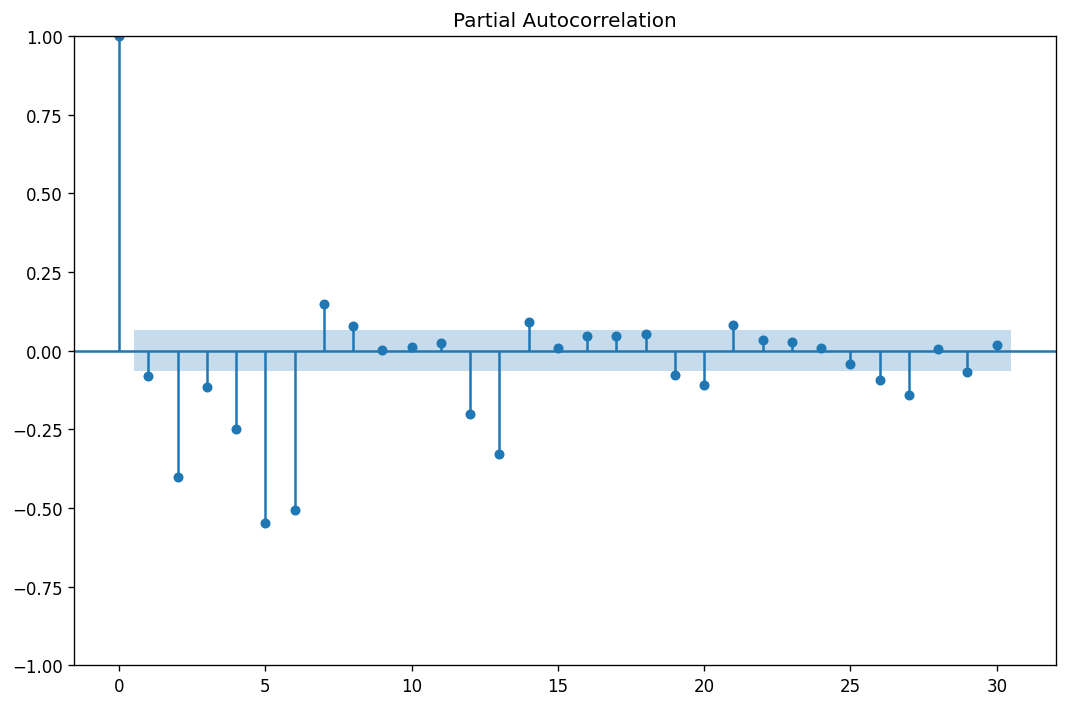

In [79]:
plot_pacf(train_data['y'].diff().dropna())
plt.tight_layout()
plt.show()

Optimal p value is 4

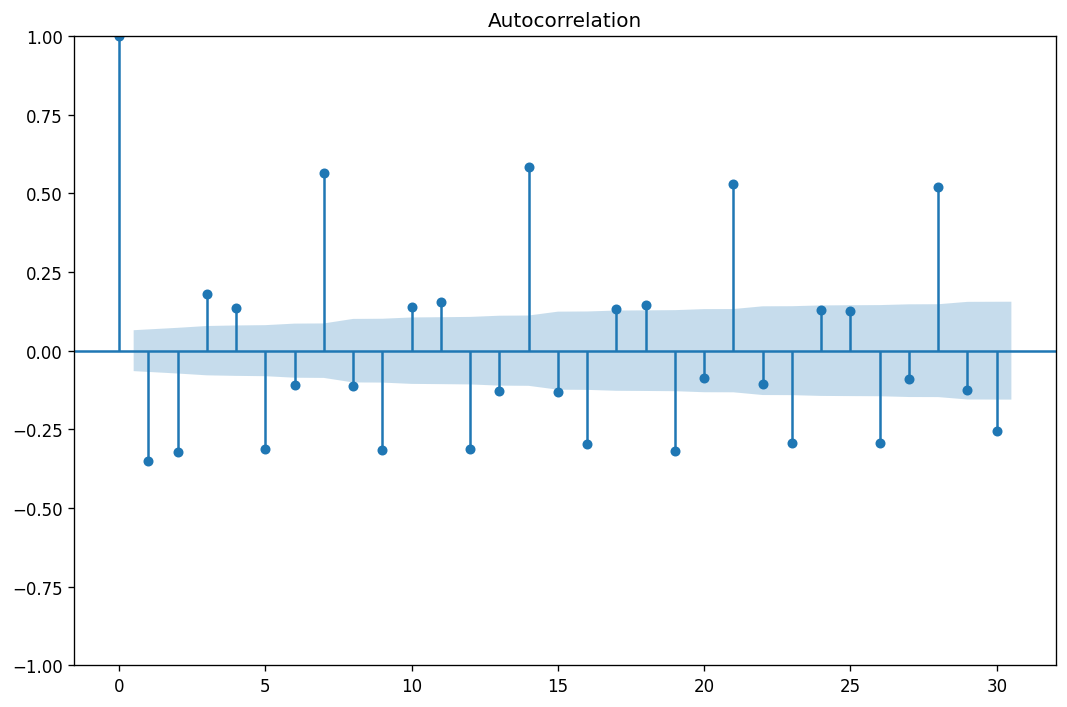

In [80]:
plot_acf(train_data['y'].diff().diff().dropna())
plt.tight_layout()
plt.show()

Optimal q value is 4

In [83]:
# Try different combinations of (p, d, q) values
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_aic = np.inf
best_bic = np.inf
best_order = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model
                model = ARIMA(train_data['y'], order=(p, d, q))
                model_fit = model.fit()
                
                # Get AIC and BIC
                aic = model_fit.aic
                bic = model_fit.bic
                
                # Track the best model
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                
                if bic < best_bic:
                    best_bic = bic
                    best_order = (p, d, q)
            except:
                continue

print(f"Best ARIMA order based on AIC: {best_order}")
print(f"Best ARIMA order based on BIC: {best_order}")


Best ARIMA order based on AIC: (1, 2, 3)
Best ARIMA order based on BIC: (1, 2, 3)


* ACF and PACF are visual tools that may not capture all nuances of the data.
* Grid search optimizes parameters to minimize AIC/BIC, potent.

So, I trained model with p values 1, and 4, and q value 3 and 4, choose those values having less mape. So, p values 4 and q value 3 gives best mape value

In [94]:
# Fit an ARIMA model on the training data.
p, d, q = 4, 2, 3
arima_model = sm.tsa.ARIMA(train_data['y'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Generate forecasts for the next 'prediction_days'
forecast_index = pd.date_range(start=forecast_start_date, periods=prediction_days, freq='D')
forecast = arima_model_fit.forecast(steps=prediction_days)

# Create a DataFrame for the forecasted values
forecast_df = pd.DataFrame({'ds': forecast_index, 'yhat': forecast})

# Prepare the true test data for evaluation (30 days of actual data after the forecast_start_date)
df_produce_copy = df_produce_copy.rename(columns={'date': 'ds', 'y': 'ytrue'})
test_data = df_produce_copy[
    (df_produce_copy['ds'] >= pd.to_datetime(forecast_start_date))]

# Merge predicted values and actual values for evaluation
df_result = pd.merge(forecast_df, test_data, on='ds')
mape = mean_absolute_percentage_error(df_result['ytrue'], df_result['yhat'])
print(f"MAPE: {mape:.4f}")  # MAPE in fraction


MAPE: 0.1460


e:\Data Science Bootcamp\DS_W1\sales_data\env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


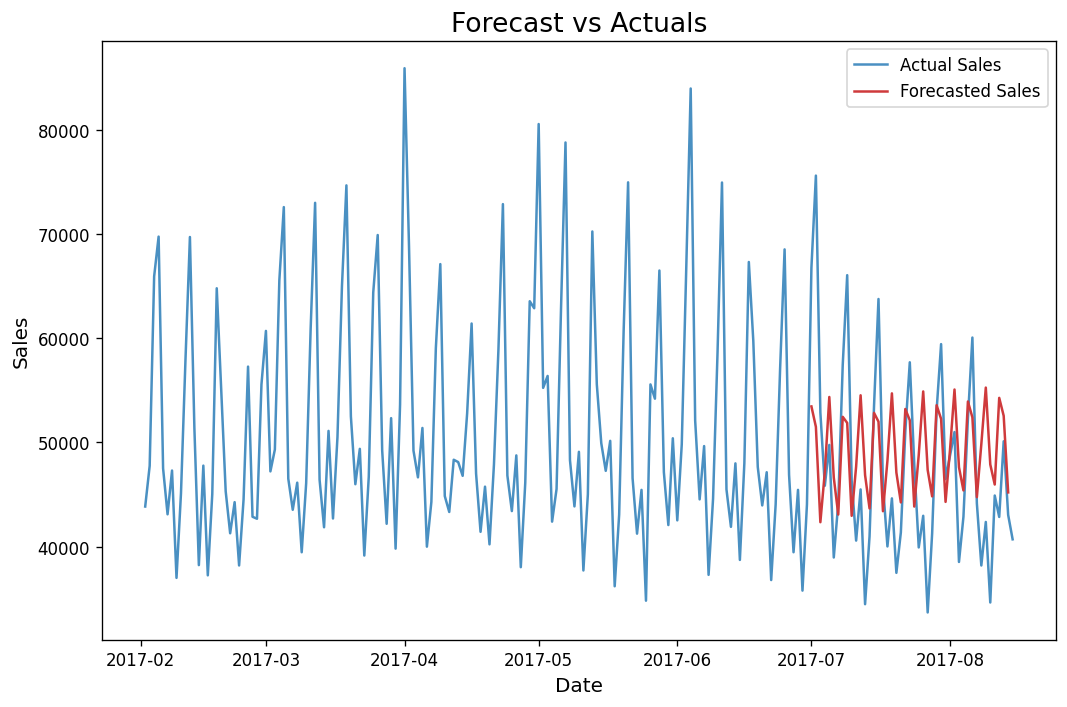

In [95]:
df_ptlot = df_produce_copy[(df_produce_copy['ds']>datetime(2017,2,1))]

# Plot historical data
plt.plot(df_ptlot.ds, df_ptlot['ytrue'], label='Actual Sales', color='#4a90c2')

# Plot forecasted values
plt.plot(forecast_df['ds'], forecast_df['yhat'], label='Forecasted Sales', color='#cf3a3c')

# Add titles and labels
plt.title("Forecast vs Actuals", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Conclusion:


So, from the results, I can see mape for feature PRODUCE using Arima model with optimal values of p, d and q is 0.1048 which is greater than mape using Prohphet model 0.0539, for feature DIARY using Arima model is 0.1460 which is greater than mape using Prohphet model 0.0648, So, I have selected Prophet model for forecasting. 